In [365]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor



IMPORTING THE DATASET


In [366]:
train_df = pd.read_csv('train1.csv')
test_df = pd.read_csv('test.csv')
train_df

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
...,...,...,...,...,...,...
136945,136945,2021-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,700
136946,136946,2021-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,752
136947,136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111
136948,136948,2021-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,641


OVERVIEW OF THE DATASET

In [367]:
overview = pd.DataFrame()
overview['columns'] = train_df.columns
overview['DataType'] = train_df.dtypes.values
overview['MissingValues'] = train_df.isnull().sum().values
overview['UniqueValues'] = train_df.nunique().values
overview

,columns,DataType,MissingValues,UniqueValues
0,id,int64,0,136950
1,date,object,0,1826
2,country,object,0,5
3,store,object,0,3
4,product,object,0,5
5,num_sold,int64,0,1028


SALES DISTRIBUTION

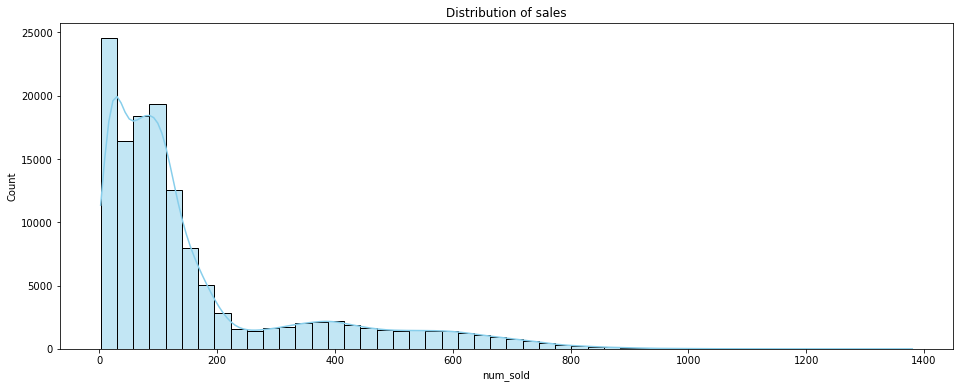

In [368]:
plt.figure(figsize = (16,6))
sns.histplot(train_df['num_sold'], bins = 50 ,kde = True, color = 'skyblue')
plt.title('Distribution of sales')
plt.show()


TIMESERIES PLOT FOR SALES

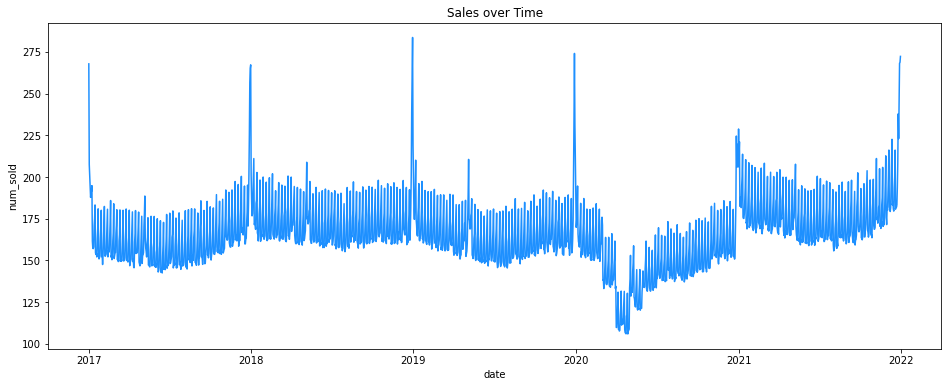

In [369]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
plt.figure(figsize = (16,6))
sns.lineplot(x = 'date', y = 'num_sold', data = train_df, ci = None, color = 'dodgerblue')
plt.title('Sales over Time')
plt.show()

SALES BY COUNTRY

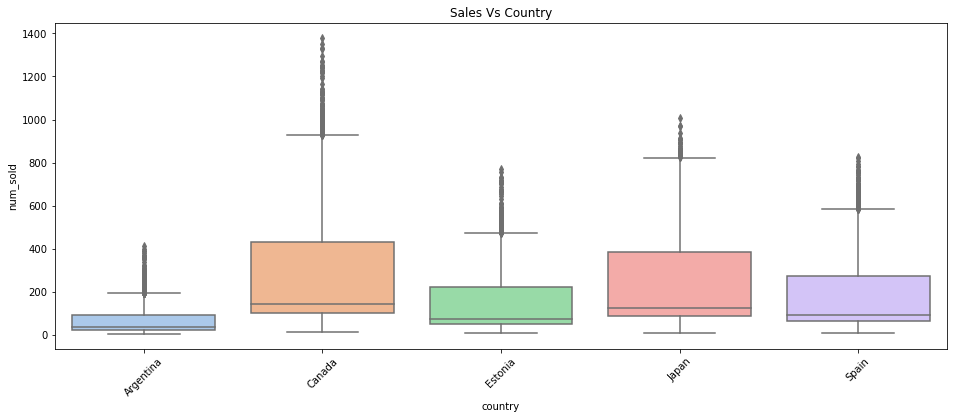

In [370]:
plt.figure(figsize = (16,6))
sns.boxplot(x = 'country', y = 'num_sold', data = train_df,palette = 'pastel')
plt.title('Sales Vs Country')
plt.xticks(rotation = 45)
plt.show()

SALES BY STORE

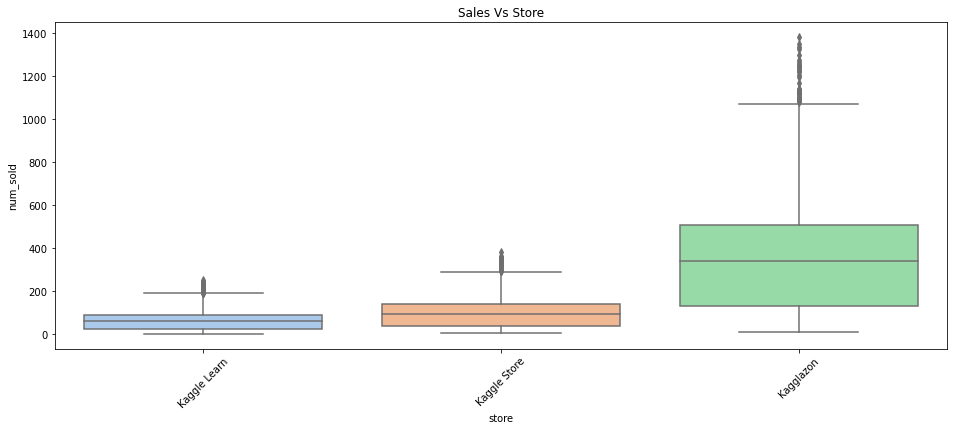

In [371]:
plt.figure(figsize = (16,6))
sns.boxplot(x = 'store', y = 'num_sold', data = train_df,palette = 'pastel')
plt.title('Sales Vs Store')
plt.xticks(rotation = 45)
plt.show()

EXTRACTION OF YEAR/MONTH/DAY

In [372]:
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day_of_week'] = train_df['date'].dt.dayofweek

test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day_of_week'] = test_df['date'].dt.dayofweek


train_df = train_df.drop(columns = ['date'])
test_df = test_df.drop(columns = ['date'])

train_df.head(5)

,id,country,store,product,num_sold,year,month,day_of_week
0,0,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,6
1,1,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,6
2,2,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,2017,1,6
3,3,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,2017,1,6
4,4,Argentina,Kaggle Learn,Using LLMs to Write Better,49,2017,1,6


ONE HOT ENCODING

In [360]:
train_encoded = pd.get_dummies(train_df, columns=['country','store','product'],drop_first = True)

test_encoded = pd.get_dummies(test_df, columns=['country','store','product'],drop_first = True)

# Ensure Train and Test Data Have same set of features

column_set = set(train_encoded.columns) - set(test_encoded.columns)

for c in column_set:
    test_encoded[c] = 0
    


test_encoded.head(5)


    

,id,year,month,day_of_week,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,num_sold
0,136950,2022,1,5,0,0,0,0,1,0,0,0,0,0,0
1,136951,2022,1,5,0,0,0,0,1,0,1,0,0,0,0
2,136952,2022,1,5,0,0,0,0,1,0,0,1,0,0,0
3,136953,2022,1,5,0,0,0,0,1,0,0,0,1,0,0
4,136954,2022,1,5,0,0,0,0,1,0,0,0,0,1,0


SPLITTING THE DATA INTO TRAIN AND TEST

In [288]:
X = train_encoded.drop(columns = ['id', 'num_sold'])
y = train_encoded['num_sold']
X_train, X_val, y_train, y_val = train_test_split(X, y ,test_size = 0.2, random_state = 42)

X_train.shape, X_val.shape

((109560, 13), (27390, 13))

Initializing Models

In [295]:
models = {
    'Linear Regression' : LinearRegression(),
    'Random Forest' : RandomForestRegressor(random_state=42),
    'Gradient Boosting' : GradientBoostingRegressor(random_state=42),
    'XGboost':XGBRegressor(random_state=42)
}

rmse = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse[name] = np.sqrt(mean_squared_error(y_val, y_pred))
    
rmse

{'Linear Regression': 91.41683057504346,
 'Random Forest': 23.378404417170028,
 'Gradient Boosting': 53.1541001653746,
 'XGboost': 21.276000786755542}

HYPERPARAMETRE TUNING FOR THE BEST MODEL (HERE XGB BOOST)

In [ ]:
param_grid = {
    'learning_rate':[0.01, 0.05, 0.1],
    'max_depth':[3,5,7,10,20],
    'n_estimators':[50,100,150,200],
    
}

xgb_grid = GridSearchCV(XGBRegressor(random_state = 42),
                        param_grid,
                        cv = 3,
                        scoring = 'neg_mean_squared_error',
                        verbose = 2,
                        n_jobs = -1)

xgb_grid.fit(X_train, y_train)

TESTING

In [301]:
best_model = xgb_grid.best_estimator_
y_pred_val = best_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f'Validation RMSE with best XGBOOST is : {rmse_val}')

Validation RMSE with best XGBOOST is : 20.696420047087305


BEST PARAMETERS

In [302]:
best_params = xgb_grid.best_params_
best_rmse = np.sqrt(-xgb_grid.best_score_)
best_params, best_rmse

({'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200},
 20.84328972067065)

BEST FEATURES

In [ ]:
importance = best_model.feature_importances_
feature_importance_series = pd.Series(importance, index = X_train.columns).sort_values(ascending = False)
feature_importance_series






TESTING ON FINAL KAGGLE TEST SET

In [362]:
test = test_encoded.drop(columns=['id','num_sold'])
test_pred = best_model.predict(test)
for i in range(len(test_pred)):
    test_pred[i] = round(test_pred[i])
submission = pd.concat([test_encoded['id'],pd.DataFrame(test_pred, columns=['num_sold'])], axis = 1)
submission.to_csv('submission.csv', index = False)
